**Лабораторную работу выполнили:** Нагайцев И.В., Резанов В.Д. \\
**Группа:** М19-ИВТ-3 \\
**Исходный код по ссылке:** https://colab.research.google.com/drive/15ku3NIltZXnlvS-CPZyPy2AYYntitAt5?usp=sharing  \\
**Задача:** Предсказать стоимость каждого дома


# Установка Keras Tuner

In [1]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 3.6MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78937 sha256=851c8ed8e9bdf1fcbbf1f63052f77676b855e8816b1662900c01085052707316
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=fd2c9f829e15820d2689a29c43f521e609206b8be35a3c6158cb260837cc07a8
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


# Импорт модулей

In [2]:
import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback
from kerastuner.tuners import Hyperband
import IPython

# Загрузка данных

In [4]:
data = pd.read_csv('/content/drive/My Drive/data_analystic/lab1/train.csv')
data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,...,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,no,0,0,1,no,no,no,yes,no,no,no,...,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,NaN,1,0,17,6,no,0,11,4,no,no,no,no,no,no,no,...,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,...,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452


# Подготовка данных

Удаление столбцов id и timestamp

In [5]:
del data['id']
del data['timestamp']
data.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,no,86206,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
1,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,no,76284,...,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
2,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,no,0,0,1,no,no,no,yes,no,no,no,no,101982,...,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
3,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,NaN,1,0,17,6,no,0,11,4,no,no,no,no,no,no,no,no,21155,...,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
4,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,no,28179,...,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452


Сохранение значений целевого поля

In [6]:
y = data.get('price_doc')
data = data.drop('price_doc', axis=1)
y

0         5850000
1         6000000
2         5700000
3        13100000
4        16331452
           ...   
30466     7400000
30467    25000000
30468     6970959
30469    13500000
30470     5600000
Name: price_doc, Length: 30471, dtype: int64

Замена NaN и тексового значения полей на числовые *значения*

In [7]:
data[data.columns] = SimpleImputer(strategy="most_frequent").fit_transform(data[data.columns])
df = pd.DataFrame(data)
data = df.apply(preprocessing.LabelEncoder().fit_transform)
data.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,...,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,38,22,4,17,0,112,2,1,1,0,9,49,135,86,2,136,112,5,134,113,5,0,15,1,0,7,3,0,0,13,1,0,0,0,0,0,0,0,0,78,...,68,776,442,921,5,21,22,16,3,1,0,2,4,0,0,21,1,717,1193,29,1073,52,5130,152,2963,2113,3261,12,39,48,40,9,4,0,13,22,1,0,52,4
1,29,14,3,17,0,112,2,1,1,0,70,87,113,117,46,115,82,5,124,61,8,0,14,1,0,6,1,1,1,3,0,0,0,0,0,0,0,0,0,59,...,30,630,479,903,1,11,11,4,2,1,0,1,7,0,6,19,1,449,2349,66,3540,40,3559,177,1506,1251,1892,9,49,65,36,15,3,0,15,29,1,10,66,14
2,38,24,2,17,0,112,2,1,1,0,129,29,95,63,70,100,30,4,102,46,7,0,44,1,0,5,1,0,0,0,1,0,0,0,1,0,0,0,0,89,...,41,1848,1265,2557,2,9,17,9,3,1,0,0,11,0,0,20,6,776,2003,43,2361,35,2563,122,2698,2332,3353,10,29,45,25,10,3,0,11,27,0,4,67,10
3,84,45,9,17,0,112,2,1,1,0,65,108,143,87,56,143,117,9,143,122,10,0,22,1,0,17,6,0,0,11,4,0,0,0,0,0,0,0,0,21,...,32,2302,1515,3016,0,5,14,10,3,0,0,1,2,0,0,18,3,825,253,8,137,22,547,61,6784,5909,7410,4,7,21,15,11,2,1,4,4,0,0,26,3
4,72,72,4,17,0,112,2,1,1,0,6,77,106,6,38,97,84,7,110,87,9,0,23,4,2,22,2,0,0,10,28,0,0,0,1,1,0,0,0,25,...,712,4189,2993,5060,63,245,252,241,145,57,4,70,120,1,40,77,5,296,954,651,5604,114,4794,1444,5841,4912,6389,143,544,545,525,317,108,17,135,236,2,91,195,14


Стандартизация данных

In [8]:
mean = data.mean(axis=0)
std = data.std(axis=0)
data -= mean
data /= std
data.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,...,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,-0.514273,-0.220294,-0.687254,0.520448,-0.441364,0.697615,0.089129,-0.749251,-0.09228,-0.752845,-1.719242,-0.944782,1.286742,0.227577,-1.519120,1.301683,1.447118,0.322957,1.254222,1.219696,0.100496,-0.329039,-0.845181,-0.214947,-0.311619,0.096585,0.121371,-0.259894,-0.215323,2.340583,-0.504653,-0.239572,-0.286803,-0.099041,-0.744731,-0.196784,-0.319471,-0.170724,-0.333139,0.123527,...,-0.105479,-0.997201,-0.927365,-1.060383,-0.123040,-0.077171,-0.111629,-0.144109,-0.253868,-0.216346,-0.254776,-0.267489,-0.324997,-0.444546,-0.301506,0.040368,-0.581079,-0.934348,0.547798,-0.273567,-0.167581,0.914065,2.205223,-0.191584,-0.227843,-0.372290,-0.249458,-0.174544,-0.214420,-0.198596,-0.185810,-0.314262,-0.238989,-0.326969,-0.070249,-0.174274,0.915161,-0.420238,-0.016753,-0.406419
1,-0.938772,-0.673901,-0.875884,0.520448,-0.441364,0.697615,0.089129,-0.749251,-0.09228,-0.752845,-0.165287,0.026858,0.816816,1.002847,-0.371693,0.850795,0.444167,0.322957,1.039337,-0.544480,0.997274,-0.329039,-0.903675,-0.214947,-0.311619,-0.071656,-0.663581,3.847593,1.011738,-0.237698,-0.661289,-0.239572,-0.286803,-0.099041,-0.744731,-0.196784,-0.319471,-0.170724,-0.333139,-0.299394,...,-0.342323,-1.085104,-0.896692,-1.069850,-0.349634,-0.243559,-0.295055,-0.352012,-0.279440,-0.216346,-0.254776,-0.332379,-0.205792,-0.444546,0.180016,-0.065767,-0.581079,-1.216078,2.645362,-0.022053,1.236494,0.412478,1.240829,-0.117002,-0.881022,-0.817661,-0.822108,-0.264717,-0.131614,-0.056445,-0.219793,-0.231998,-0.274218,-0.326969,-0.001564,-0.026432,0.915161,0.065653,0.286146,1.638898
2,-0.514273,-0.106893,-1.064514,0.520448,-0.441364,0.697615,0.089129,-0.749251,-0.09228,-0.752845,1.337718,-1.456171,0.432331,-0.347624,0.254176,0.528732,-1.294283,-0.016440,0.566591,-1.053377,0.698348,-0.329039,0.851130,-0.214947,-0.311619,-0.239896,-0.663581,-0.259894,-0.215323,-1.011183,-0.504653,-0.239572,-0.286803,-0.099041,1.342722,-0.196784,-0.319471,-0.170724,-0.333139,0.368376,...,-0.273763,-0.351783,-0.245098,-0.199896,-0.292986,-0.276837,-0.195005,-0.265386,-0.253868,-0.216346,-0.254776,-0.397269,-0.046852,-0.444546,-0.301506,-0.012700,1.620072,-0.872325,2.017544,-0.178399,0.565475,0.203483,0.629412,-0.281082,-0.346643,-0.259139,-0.210974,-0.234659,-0.297227,-0.223682,-0.313248,-0.300551,-0.274218,-0.326969,-0.138933,-0.068673,-0.726150,-0.225882,0.307781,0.820771
3,1.655388,1.083825,0.255896,0.520448,-0.441364,0.697615,0.089129,-0.74925

# Создание и обучение нейронной сети

In [10]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state = 2)

Создание и обучение нейронной сети

In [11]:
model = Sequential()
model.add(Dense(512, activation="relu", input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(248, activation="relu"))
model.add(Dense(122, activation="relu"))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
 
model.summary()

history = model.fit(x_train, y_train, epochs=50, batch_size=125, verbose=2, validation_split=0.3)
print(history)
history = history.history
print("[INFO] Training has been finished")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               148480    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 248)               127224    
_________________________________________________________________
dense_2 (Dense)              (None, 122)               30378     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 123       
Total params: 306,205
Trainable params: 306,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
120/120 - 1s - loss: 72901189435392.0000 - mae: 7062454.5000 - val_loss: 69649597202432.0000 - val_mae: 6

Создание графика

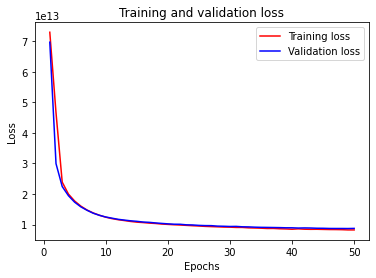

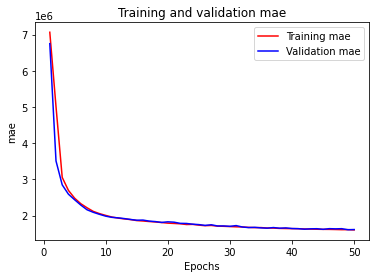

In [12]:
def graphs(history):
    loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(1, len(history['loss']) + 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
 
    plt.clf()
 
    mae = history['mae']
    val_mae = history['val_mae']
    plt.plot(epochs, mae, 'r', label='Training mae')
    plt.plot(epochs, val_mae, 'b', label='Validation mae')
    plt.title('Training and validation mae')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

graphs(history)

Предсказание и подсчет коэффициента корелляции

In [13]:
predicted_y = model.predict(x_test)
predicted_y = np.reshape(predicted_y, (predicted_y.shape[0]))

cc = np.corrcoef(predicted_y, y_test)
cc = cc[0][1]
print(f'Correlation Coefficient: {cc}')

Correlation Coefficient: 0.7902382889374678


# Keras Tuner

Создание модели

In [14]:
def build_model(hp):
  hidden_layers = hp.Choice('hidden_layers', values=[1,2,3])
  activation_choice = hp.Choice('activation', values=['relu', 'selu', 'elu'])
  model = Sequential()
  model.add(Dense(units=hp.Int('units',min_value=256,max_value=512,step=32),activation=activation_choice, input_shape=(x_train.shape[1], )))
  model.add(Dropout(0.3))
  for i in range(hidden_layers):
    model.add(Dense(units=hp.Int(f'layer_{i}_units_',min_value=32//(i+1), max_value=128//(i+1),step=64//(i+1)),activation=activation_choice))
  model.add(Dense(1))  
  model.compile(optimizer='rmsprop', loss="mse", metrics=["mae"])
  return model

Поиск лучшей модели, используя Hyperband

In [15]:
def find_best(x_train, y_train):
  # создается тюнер, который сможет подобрать оптимальную архитектуру модели
  tuner = Hyperband(build_model, objective="loss", max_epochs=10, hyperband_iterations=3)
  print("\n\n\n")
  # начинается автоматический подбор гиперпараметров
  print('[INFO] start searching')
  tuner.search(x_train, y_train, batch_size=128, epochs=10, validation_split=0.2)
  # выбирается лучшую модель
  print("\n\n\nRESULTS SUMMARY")
  tuner.results_summary()
  print("\n\n\n")
  # получаем лучшую модель
  print("\n\n\nHERE IS THE BEST MODEL\n\n\n")
  best_params = tuner.get_best_hyperparameters()[0]
  best_model = tuner.hypermodel.build(best_params)
  best_model.summary()
  return best_model
  

best_model = find_best(x_train, y_train)

Trial 90 Complete [00h 00m 06s]
loss: 68386813902848.0

Best loss So Far: 12464188030976.0
Total elapsed time: 00h 06m 47s
INFO:tensorflow:Oracle triggered exit



RESULTS SUMMARY
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
hidden_layers: 3
activation: elu
units: 512
layer_0_units_: 96
layer_1_units_: 48
layer_2_units_: 31
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 12464188030976.0
Trial summary
Hyperparameters:
hidden_layers: 3
activation: relu
units: 352
layer_0_units_: 96
layer_1_units_: 48
layer_2_units_: 31
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 3211abfa11950fa30fdcda830d6f11ec
Score: 17708127092736.0
Trial summary
Hyperparameters:
hidden_layers: 3
activation: relu
units: 288
layer_0_units_: 96
layer_1_units_: 48
layer_2_units_: 31
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1


Обучение лучшей модели

In [16]:
best_history = best_model.fit(x_train, y_train, epochs=50, batch_size=125, validation_split=0.3)
best_history = best_history.history
print("[INFO] Training has been finished")

Epoch 1/50
120/120 [==============================] - 1s 10ms/step - loss: 73421853556736.0000 - mae: 7100975.5000 - val_loss: 73537289191424.0000 - val_mae: 7032401.0000
Epoch 2/50
120/120 [==============================] - 1s 8ms/step - loss: 63112740864000.0000 - mae: 6430421.0000 - val_loss: 52873140371456.0000 - val_mae: 5644375.5000
Epoch 3/50
120/120 [==============================] - 1s 8ms/step - loss: 39259016790016.0000 - mae: 4476925.5000 - val_loss: 31481997033472.0000 - val_mae: 3653762.2500
Epoch 4/50
120/120 [==============================] - 1s 9ms/step - loss: 27276246777856.0000 - mae: 3414355.0000 - val_loss: 26621075521536.0000 - val_mae: 3277940.0000
Epoch 5/50
120/120 [==============================] - 1s 9ms/step - loss: 24330171842560.0000 - mae: 3171127.5000 - val_loss: 24384020414464.0000 - val_mae: 3121645.5000
Epoch 6/50
120/120 [==============================] - 1s 8ms/step - loss: 22285503168512.0000 - mae: 3011422.0000 - val_loss: 22358270148608.0000 - v

Создание графиков лучшей модели

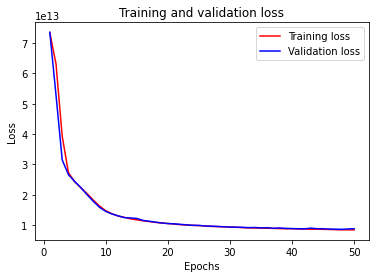

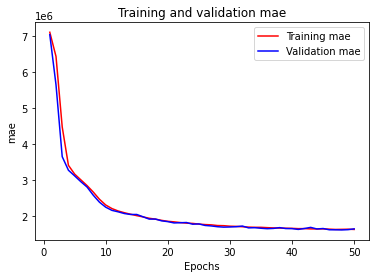

In [17]:
graphs(best_history)

Предсказания и подсчет коэффициента корреляции лучшей модели

In [18]:
best_predicted_y = best_model.predict(x_test)
best_predicted_y = np.reshape(best_predicted_y, (best_predicted_y.shape[0]))

best_cc = np.corrcoef(best_predicted_y, y_test)
best_cc = best_cc[0][1]
print(f'Correlation Coefficient: {best_cc}')

Correlation Coefficient: 0.7927187860547827
